# Image Alignment Tests
Our microscopy images drift signficiantly over time, which frustrates us being able to study how voids move between images.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from skimage.transform import AffineTransform, warp
from scipy.signal import fftconvolve
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
import imageio

Configuration

In [19]:
run_directory = '../data/8bitTIFF-video26-575C/'

Initialize the output directory

In [27]:
run_directory = Path(run_directory)
out_directory = Path('output') / run_directory.name
out_directory.mkdir(exist_ok=True, parents=True)
(out_directory / 'figures').mkdir(exist_ok=True)

## Get a list of images
We use the masks of void locations in the images as the FFT-based translation codes seem to work best with dealing with high-contrast images

In [28]:
images = sorted((run_directory / 'masks/').glob('*tif'))
print(f'Found {len(images)} images')

Found 969 images


## Determine the correction
The idea is to determine drift by computing the [cross-correlation between the two images](https://en.wikipedia.org/wiki/Cross-correlation#/media/File:Cross_correlation_animation.gif). 
The largest peak in the cross-correlation will correspond to the translation that leads to the greatest overlap between the two images.
Due to same [math I don't understand](https://en.wikipedia.org/wiki/Discrete_Fourier_transform#Circular_convolution_theorem_and_cross-correlation_theorem), you can compute this cross-correlation very quickly using Fourier Transforms with [SciPy](https://stackoverflow.com/questions/24768222/how-to-detect-a-shift-between-images).

In [29]:
image_1 = imageio.read(images[0]).get_data(0)
image_2 = imageio.read(images[20]).get_data(0)

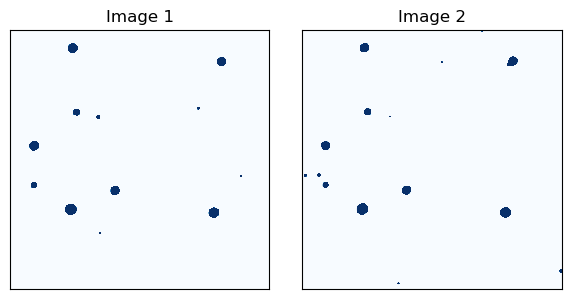

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3),)

for ax in axs:
    ax.set_yticks(ax.set_xticks([]))

# Plot the original and new overlapped
axs[0].imshow(image_1, cmap='Blues', vmin=0, vmax=1)
axs[0].set_title('Image 1')

# Plot the re-registered images
axs[1].imshow(image_2, cmap='Blues', vmin=0, vmax=1)
axs[1].set_title('Image 2')

fig.tight_layout()

It seems like image is drifting to the left and down.

In [31]:
def compute_drift(image_1: np.ndarray, image_2: np.ndarray) -> np.ndarray:
    """Compute the drift between two different frames
    
    Args:
        image_1: Starting image
        image_2: Next image
    Returns:
        - The optimal translation between the two images
        - Convolution used to make the judgement
    """
    
    # Compute the correlations between the two images using FFT
    #  You must reverse the second signal/image for this trick
    conv = fftconvolve(image_1, image_2[::-1,::-1], mode='same')
    
    # Find the location of the maximum
    peak_loc = np.unravel_index(np.argmax(conv), conv.shape)
    
    # Find its deplacement from the image center, that's the location
    drift = [peak_loc[1] - conv.shape[0] // 2 , peak_loc[0] - conv.shape[1] // 2]
    return -np.array(drift), conv
drift, conv = compute_drift(image_1, image_2)
drift

array([-2, -1])

We can see the image drifted to the left (-x) and down (y)

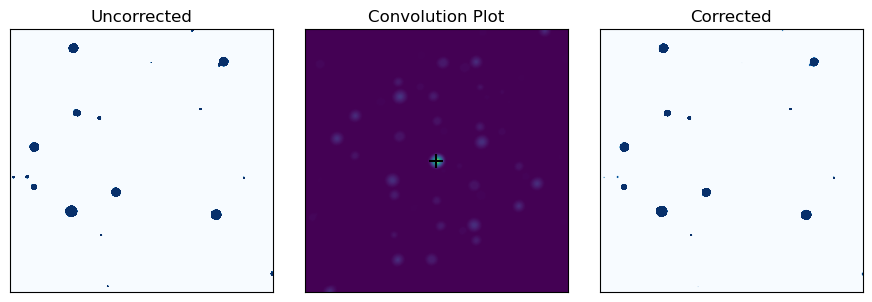

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3),)

for ax in axs:
    ax.set_yticks(ax.set_xticks([]))

# Plot the original and new overlapped
axs[0].imshow(0.5 * image_1 + image_2, cmap='Blues', vmin=0, vmax=1)
axs[0].set_title('Uncorrected')

# Plot the convolution
axs[1].scatter([image_1.shape[0] // 2], [image_1.shape[1] // 2], marker='+', s=100., color='k')
axs[1].imshow(conv)
axs[1].set_title('Convolution Plot')

# Plot the re-registered images
affine = AffineTransform(translation=drift)
image_2_shift = warp(image_2, affine)
axs[2].imshow(0.5 * image_1 + image_2_shift, cmap='Blues', vmin=0, vmax=1)
axs[2].set_title('Corrected')

fig.tight_layout()
fig.savefig(out_directory / 'figures/drift-correlation.png', dpi=320)

The light and dark blue in the left image are the voids at different times. You can see the pattern drifts "up to the right" between them, which is reflected in the peak of the cross-correlation being up and to the right. 
Applying that transformation yields the two mapped directly atop each other.

## Apply to the whole stack
We can now compute the drift between successive images in the stack to get the total drift over time

In [33]:
stepwise_drifts = [
    compute_drift(imageio.v3.imread(x), imageio.v3.imread(y))[0]
    for x, y in tqdm(zip(images, images[1:]))
]

968it [01:32, 10.41it/s]


Plot how the drift goes over time.

In [34]:
stepwise_drifts = np.vstack([[0, 0], stepwise_drifts])  # Initial frame has no drift

In [35]:
total_drift = np.cumsum(stepwise_drifts, axis=0)

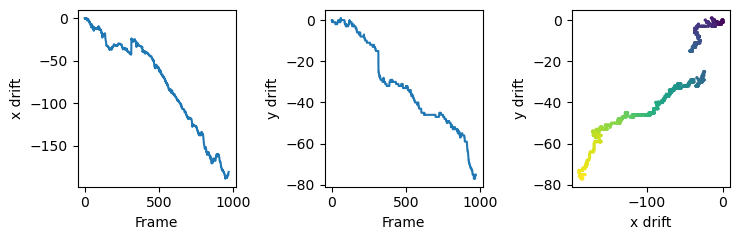

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(7.5, 2.5))

for ax, i, l in zip(axs, range(2), ['x', 'y']):
    ax.plot(total_drift[:, 1- i])
    ax.set_xlabel('Frame')
    ax.set_ylabel(l + ' drift')

axs[2].scatter(total_drift[:, 1], total_drift[:, 0], c=np.arange(total_drift.shape[0]), s=2)
axs[2].set_xlabel('x drift')
axs[2].set_ylabel('y drift')

# Plot the drifts
for ax in axs:
    ax.set_xlim(ax.get_xlim())
    ax.set_ylim(ax.get_ylim())

fig.tight_layout()
fig.savefig(out_directory / 'figures/drift-from-fft.png', dpi=320)

Save it to disk for later use

In [37]:
out_path = out_directory / 'drifts-fft.csv'
pd.DataFrame(total_drift, columns=['x', 'y']).to_csv(out_path, index_label='frame')

## Update the Void Locations
The void locations in the defect details files with the run should be updated too.

In [38]:
defect_details = pd.read_json(run_directory / 'masks' / 'defect-details.json', lines=True)

In [39]:
defect_details['positions_corrected-fft'] = [(x - y) if len(x) > 0 else x for x, y in zip(defect_details['positions'], total_drift)]
defect_details['drift'] = total_drift.tolist()

In [40]:
defect_details.to_json(out_directory / f'defect-details.json', orient='records', lines=True)